Install dependencies. (Only when running in Google Colab.)

In [86]:
!pip install torch_geometric > /dev/null
!pip install transformers > /dev/null
!pip install wandb > /dev/null
!pip install gradio > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [2]:
#Only for Google colab
%load_ext autoreload
%autoreload 2

Load dependencies

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch_geometric
import random
import torch_geometric.transforms as T
import wandb

In [8]:
if torch.cuda.is_available():
  device="cuda:0"
else:
  device="cpu"

Load own code

In [4]:
from dataset_utils import SNAPEgoDataset
import model_utils
from models import GCN, Baseline

#Reading the datasets

In [11]:
facebook_dataset_pca = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "pca")
facebook_dataset_basic = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "basic")
facebook_dataset_diff = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "diff")
gplus_dataset_diff = SNAPEgoDataset('/data/gplus', 'ego-Gplus', "diff")
twitter_dataset_diff = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "diff")
twitter_dataset_cluster = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "cluster")

#Data analysis

## General dataset information

#### Facebook

The smallest but most complete dataset according to the paper, collected specifically by the researchers. It contains 10 ego networks with a few hundred nodes on average.

It contains undirected networks and has many collected anonimized features about the users.

In [ ]:
facebook_dataset_basic.print_summary()
print(f"Node feature size: {facebook_dataset_basic.num_features}")

SNAPEgoDataset (#graphs=10):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    417.7 |  17850.8 |
| std        |    347.4 |  23078.2 |
| min        |     60   |    410   |
| quantile25 |    162.8 |   3665   |
| median     |    228   |   5732   |
| quantile75 |    704   |  24904   |
| max        |   1046   |  61560   |
+------------+----------+----------+
Node feature size: 1406


#### Google+

The Google+ dataset contains 129 scraped ego networks of Google+ users in wildly varying sizes, from a few dozen to several thousand. Since Google+ is based on users following eachother the networks are directed.

The node features come from a long list of possible features which are described by a binary vector for all nodes. This way the data is both too large to be handled in memory and too high in dimensionality:

We took a similar approach to the original paper in handling this high dimensional data: we separated it by the given categories and reduced to a single number per category during the dataset processing step.

In [ ]:
gplus_dataset_diff.print_summary()
print(f"Node feature size: {gplus_dataset_diff.num_features}")

SNAPEgoDataset (#graphs=129):
+------------+----------+-----------------+
|            |   #nodes |          #edges |
|------------+----------+-----------------|
| mean       |   1991.5 | 238383          |
| std        |   1697.4 | 341734          |
| min        |     36   |     95          |
| quantile25 |    486   |  14332          |
| median     |   1485   |  78763          |
| quantile75 |   3532   | 331421          |
| max        |   4965   |      1.6239e+06 |
+------------+----------+-----------------+
Node feature size: 60


#### Twitter

The Twitter dataset is also a scraped, undirected dataset, containing by far the most (973) graphs. It generally contains fewer nodes than the gplus dataset, usually between 100 and 200.

Node features come from tweets rather than a filled out user profile: the collected features reflect the two-week period before the scrape and contain hashtags and mentions. This data is stored as a binary vector similarly to the Google+ one and poses similar problems.

We created two solutions to deal with this:
- One mentioned in the paper, recording the number of hashtags and mentions used in common with the ego of the network, reducing dimensionality to 2 and
- Our own solution, which clusters the names of the tags and mentions using a Bert model and records how many were used from each cluster, reducing dimensionality to 50

In [ ]:
twitter_dataset_diff.print_summary()
print(f"Node feature size: {twitter_dataset_diff.num_features}")

SNAPEgoDataset (#graphs=973):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    138.6 |   2625.5 |
| std        |     65.9 |   2272.1 |
| min        |     11   |     31   |
| quantile25 |     85   |    847   |
| median     |    141   |   2046   |
| quantile75 |    196   |   3812   |
| max        |    251   |  18358   |
+------------+----------+----------+
Node feature size: 2
Node feature size: 50


## Node and edge number distribution

Node and edge numbers compared for each graph in the 3 datasets and compared across datasets. The expected quadratic correlation can be observed, even if not very neatly.

#### Facebook

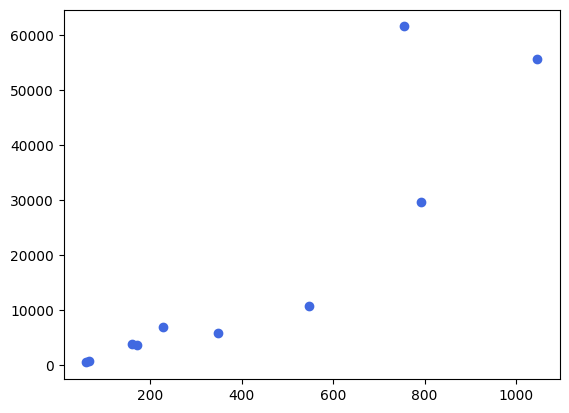

In [ ]:
num_edges_f = []
num_nodes_f = []
density_f = []
for i in range(facebook_dataset_basic.len()):
    current = facebook_dataset_basic.get(i)
    num_edges_f.append(current.num_edges)
    num_nodes_f.append(current.num_nodes)
    density_f.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1) / 2))

plt.scatter(num_nodes_f, num_edges_f, c='royalblue')

#### Google+

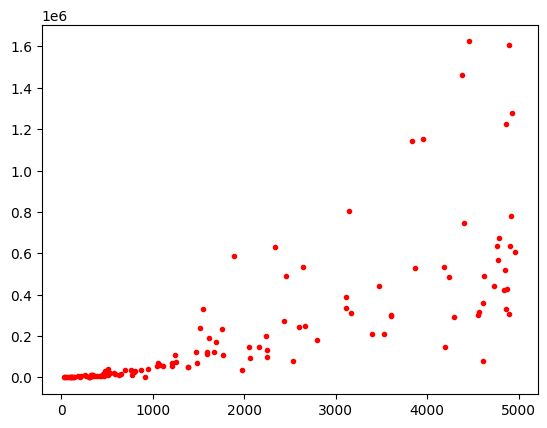

In [ ]:
num_edges_g = []
num_nodes_g = []
density_g = []
for i in range(gplus_dataset_diff.len()):
    current = gplus_dataset_diff.get(i)
    num_edges_g.append(current.num_edges)
    num_nodes_g.append(current.num_nodes)
    density_g.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1) / 2))

plt.scatter(num_nodes_g, num_edges_g, c='red', marker=".")

#### Twitter

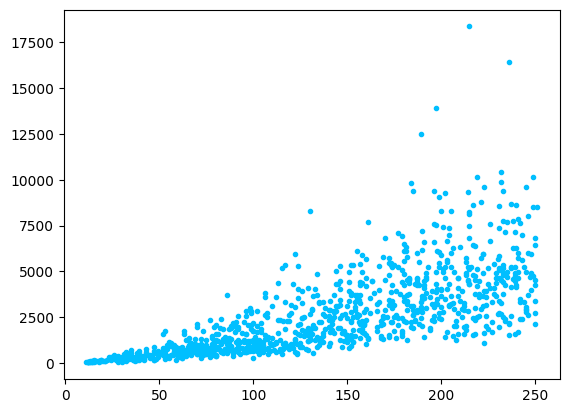

In [ ]:
num_edges_t = []
num_nodes_t = []
density_t = []
for i in range(twitter_dataset_diff.len()):
    current = twitter_dataset_diff.get(i)
    num_edges_t.append(current.num_edges)
    num_nodes_t.append(current.num_nodes)
    density_t.append(current.num_edges/(current.num_nodes*(current.num_nodes - 1)))

plt.scatter(num_nodes_t, num_edges_t, c='deepskyblue', marker=".")

#### Overview

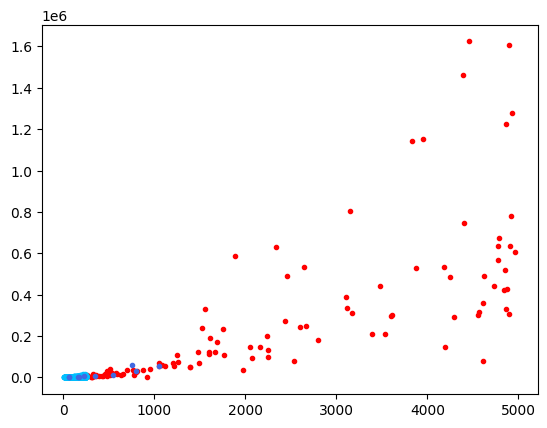

In [ ]:
plt.scatter(num_nodes_g, num_edges_g, c='red', marker=".")
plt.scatter(num_nodes_t, num_edges_t, c='deepskyblue', marker=".")
plt.scatter(num_nodes_f, num_edges_f, c='royalblue', marker=".")

## Graph density

The number of edges compared to the number of possible edges. This shows that the datasets contain graphs of various densities, although the majority is rather sparse, with only about 10-20% of possible edges occuring.

#### Facebook

<BarContainer object of 10 artists>

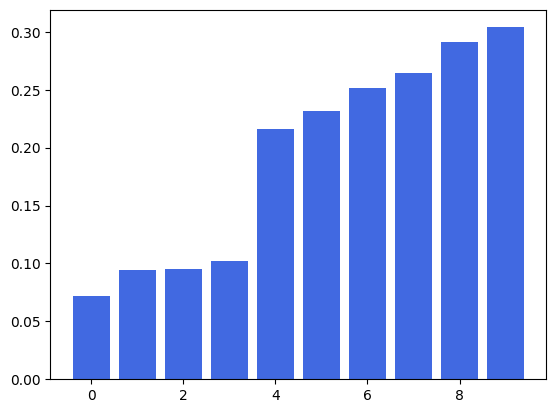

In [ ]:
plt.bar(np.arange(facebook_dataset.len()), sorted(density_f), color='royalblue')

#### Google+

<BarContainer object of 129 artists>

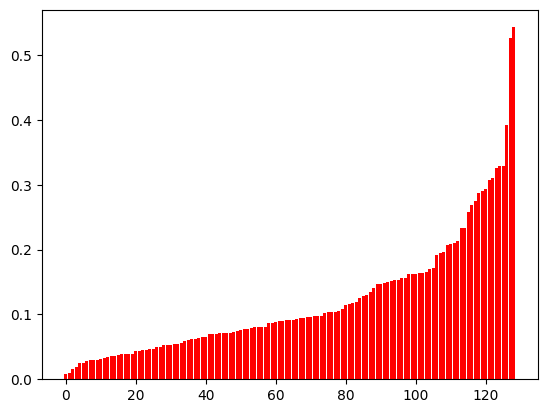

In [ ]:
plt.bar(np.arange(gplus_dataset.len()), sorted(density_g), color='red')

#### Twitter

<BarContainer object of 973 artists>

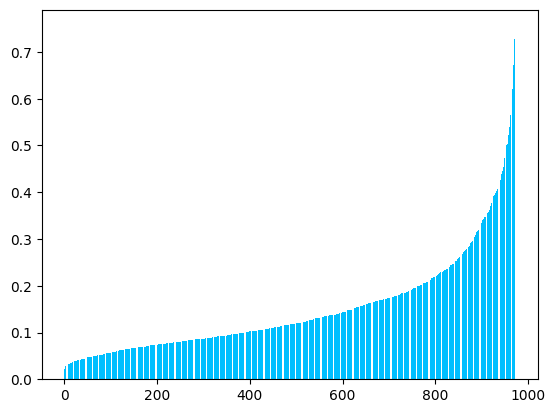

In [ ]:
plt.bar(np.arange(twitter_dataset.len()), sorted(density_t), color='deepskyblue')

#### Overview

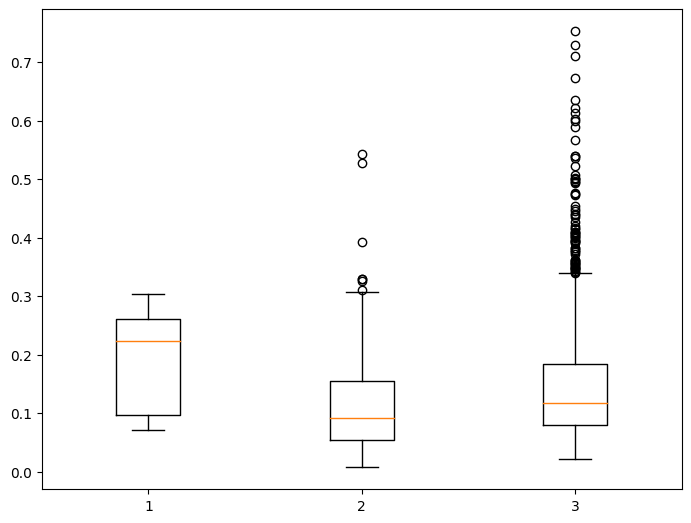

In [ ]:
data = [density_f, density_g, density_t]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.show()

## Graph visualisation

We visualize the smallest graph from each dataset to get a feel for both their size and composition.

For these visualizations we remove the ego node of the network: since it is connected to every other node in the graph it makes it very hard to read.

#### Facebook

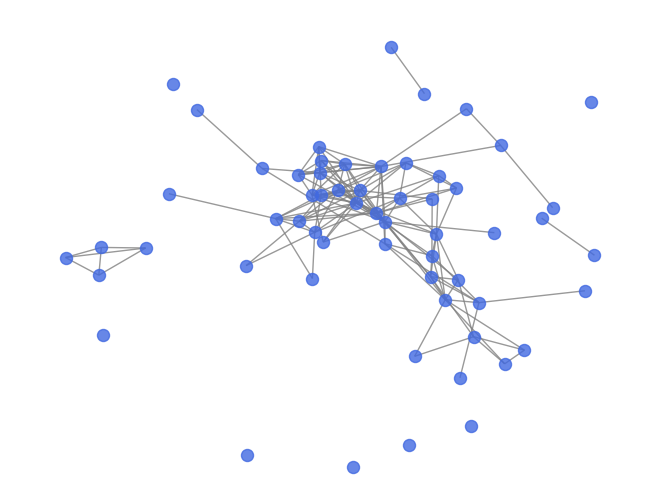

In [ ]:
smallest = facebook_dataset.get(num_nodes_f.index(min(num_nodes_f)))
G = to_networkx(smallest, to_undirected=True)
G.remove_node(min(num_nodes_f)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color='royalblue', edge_color="gray")
plt.show()

#### Google+

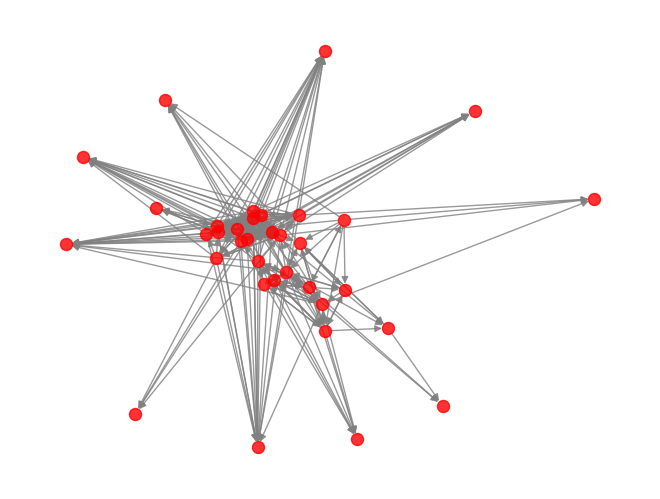

In [ ]:
smallest = gplus_dataset.get(num_nodes_g.index(min(num_nodes_g)))
G = to_networkx(smallest)
G.remove_node(min(num_nodes_g)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color="red", edge_color="gray")
plt.show()

#### Twitter

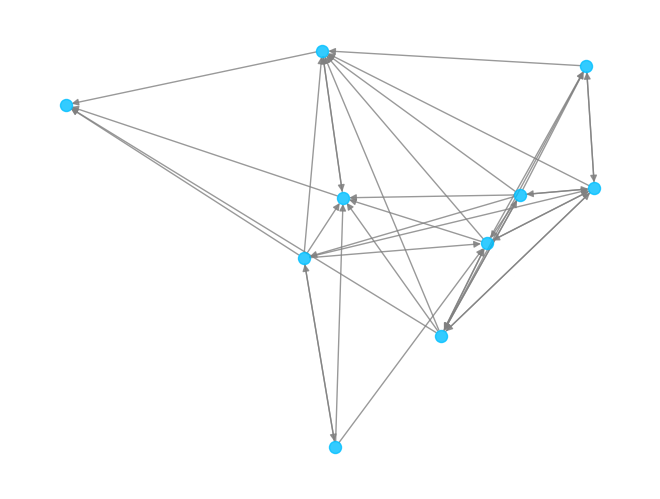

In [ ]:
smallest = twitter_dataset.get(num_nodes_t.index(min(num_nodes_t)))
G = to_networkx(smallest)
G.remove_node(min(num_nodes_t)-1)
pos = nx.spring_layout(G, iterations=50, k=0.4, seed=175)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color='deepskyblue', edge_color="gray")
plt.show()

# Data preparation



The data is prepared using Pytorch Geometric's transform functions.

RandomLinkSplit divides the edges into training, validation and test sets and even prepares negative samples for the model.


In [9]:
transform_undirected = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.0, num_test=0.0, is_undirected = True,
                      add_negative_train_samples = True, neg_sampling_ratio = 1.0,
                      disjoint_train_ratio = 0.3)
])

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0, num_test=0, is_undirected = False,
                      add_negative_train_samples = True, neg_sampling_ratio = 1.0,
                      disjoint_train_ratio = 0.3)
])

In [10]:
facebook_dataset_basic = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "basic", transform=transform_undirected)
facebook_dataset_pca = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "pca", transform=transform_undirected)
facebook_dataset_diff = SNAPEgoDataset('/data/facebook', 'ego-Facebook', "diff", transform=transform_undirected)
gplus_dataset_diff = SNAPEgoDataset('/data/gplus', 'ego-Gplus', "diff", transform=transform)
twitter_dataset_diff = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "diff", transform=transform)
twitter_dataset_cluster = SNAPEgoDataset('/data/twitter', 'ego-Twitter', "cluster", transform=transform)

datasets = [facebook_dataset_basic, facebook_dataset_pca, facebook_dataset_diff, gplus_dataset_diff, twitter_dataset_diff, twitter_dataset_cluster]
dataset_names = ["facebook_dataset_basic", "facebook_dataset_pca", "facebook_dataset_diff", "gplus_dataset_diff", "twitter_dataset_diff", "twitter_dataset_cluster"]

Extracting /data/facebook/ego-facebook/raw/facebook.tar.gz
Processing...
100%|██████████| 10/10 [00:01<00:00,  6.38it/s]
Done!
Processing...
100%|██████████| 10/10 [00:01<00:00,  9.62it/s]
Done!
Processing...
100%|██████████| 10/10 [00:01<00:00,  9.66it/s]
Done!
Extracting /data/gplus/ego-gplus/raw/gplus.tar.gz
Processing...
100%|██████████| 132/132 [02:32<00:00,  1.15s/it]
Done!
Extracting /data/twitter/ego-twitter/raw/twitter.tar.gz
Processing...
100%|██████████| 973/973 [01:05<00:00, 14.83it/s]
Done!
Processing...
100%|██████████| 973/973 [01:24<00:00, 11.55it/s]
Done!


In [11]:
def split_dataset(dataset, val_size, test_size):
    data = [a[0] for a in dataset]
    random.seed(43)
    random.shuffle(data)

    test_data = data[:int(test_size*len(data))]
    val_data = data[int(test_size*len(data)):int((test_size+val_size)*len(data))]
    train_data = data[int((test_size+val_size)*len(data)):]

    return (test_data, val_data, train_data)

In [43]:
def egonetwork_to_jsondict(graph):
  nodes = []
  for i in range(graph.x.shape[0]):
    node = dict()
    node["neighbors"] = graph.edge_index.T[graph.edge_index[0] == i].T[1].tolist()
    node["x"] = graph.x[i].tolist()
    node["id"] = i
    nodes.append(node)

  return {"nodes": nodes}

# Training models

Runs a W&B sweep on each dataset.

Log in to WandB

In [ ]:
wandb.login(relogin=True)

Configuration for the WandB sweep

In [ ]:
sweep_configuration = {
    "metric": {"name": "accuracy", "goal": "maximize"},
    "method": "bayes",
    "parameters": {
        "learning_rate": {
            'distribution': 'uniform',
            'min': 0,
            'max': 0.1
            },
        "hidden_dim": {
            "values": [32, 64, 128, 256]
        },
        "hidden_dim_linear": {
            "values": [32, 64, 128, 256]
        },
        "node_embedding_dim": {
            "values": [32, 64, 128, 256, 512]
        },
        'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
        "weight_decay": {
            'distribution': 'uniform',
            'min': 0,
            'max': 0.001
        },
        "num_layers": {
            "values": [2, 3, 4, 5, 6]
        }
    },
}

In [ ]:
dataset_name = ""

In [26]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config

        model = GCN(
            train_data[0].num_features,
            config.hidden_dim,
            config.node_embedding_dim,
            config.hidden_dim_linear,
            config.num_layers,
            config.dropout).to(device)
        model_utils.train_model(model, train_data, val_data, 100, 10, 3, dataset_name, True)

In [ ]:
for i in range(len(datasets)):
    dataset_name = dataset_names[i]
    sweep_id = wandb.sweep(sweep_configuration, project="friend-rec" + "-" + dataset_names[i])
    (test_data, val_data, train_data) = split_dataset(datasets[i], 0.1, 0.2)
    wandb.agent(sweep_id, train, count=10)

Run a training with a set of hyperparameters.

# Evaluation

ROC and PR curves, confusion matrices for each dataset.

In [172]:
from models import Baseline
from model_utils import load_model, preds_from_model
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns
import os

In [110]:
def predict_baseline_and_model(datasets, dataset_names):
  y_all = []
  y_probas_all_baseline = []
  y_preds = []
  for i in range(len(datasets)):
    #Fit baseline
    baseline = Baseline()
    (test_data, val_data, train_data) = split_dataset(datasets[i], 0.1, 0.2)
    y_a, y_probas_a_baseline = baseline.fit_predict_baseline(train_data, val_data, test_data)
    y_all.append(y_a)
    y_probas_all_baseline.append(y_probas_a_baseline)
    dataset_name = dataset_names[i]

    #Predict from model
    model = load_model(os.path.join("models", dataset_name, "best.pt"))
    y_preds.append(preds_from_model(model, test_data))

  return y_all, y_probas_all_baseline, y_preds

In [158]:
def plot_roc(dataset_names, y_all, y_probas_all_baseline, y_preds):
  fig, ax = plt.subplots()
  for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    feature_name = dataset_name.split("_")[2]

    #Calculate FPR, TPR for baseline
    fpr, tpr, thresholds = roc_curve(y_all[i], y_probas_all_baseline[i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=feature_name + ' Baseline')
    display.plot(ax)

    #Calculate FPR, TPR for GCN model
    fpr, tpr, thresholds = roc_curve(y_all[i], y_preds[i])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=feature_name + ' GCN')
    display.plot(ax)

  fig.show()
  return fig

In [153]:
def plot_pr(dataset_names, y_all, y_probas_all_baseline, y_preds):
  fig, ax = plt.subplots()
  for i in range(len(dataset_names)):
    dataset_name = dataset_names[i]
    feature_name = dataset_name.split("_")[2]

    display = PrecisionRecallDisplay.from_predictions(y_all[i], y_probas_all_baseline[i], name=feature_name +  " Baseline", pos_label=1)
    display.plot(ax=ax)

    display = PrecisionRecallDisplay.from_predictions(y_all[i], y_preds[i], name=feature_name + " GCN", pos_label=1)
    display.plot(ax=ax)

  #fig.show()
  return fig

## Facebook dataset

In [170]:
y_all, y_probas_all_baseline, y_preds = predict_baseline_and_model(datasets[0:3], dataset_names[0:3])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

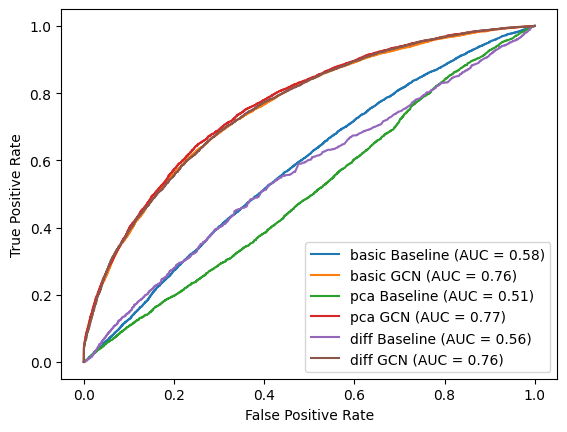

In [159]:
fig = plot_roc(dataset_names[0:3], y_all, y_probas_all_baseline, y_preds)

plt.savefig("Facebook_ROC.png")

In [ ]:
fig = plot_pr(dataset_names[0:3], y_all, y_probas_all_baseline, y_preds)

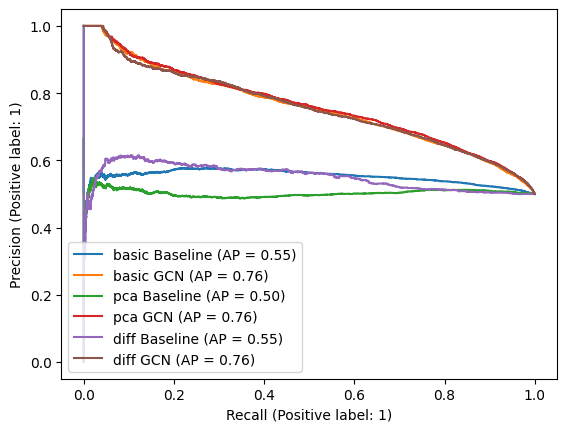

In [157]:
fig

<Axes: >

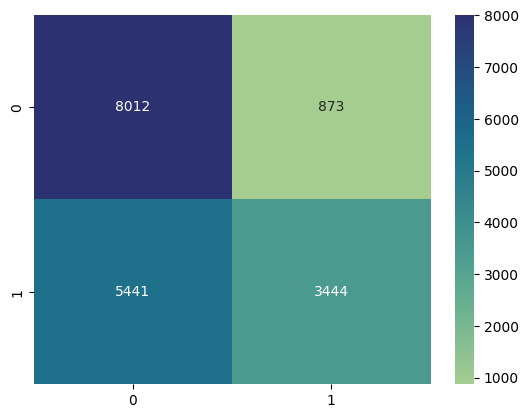

In [173]:
conf_mat = confusion_matrix(y_all[2], y_preds[2].round())
sns.heatmap(conf_mat, annot=True, cmap="crest", fmt=".0f")

In [183]:
#Accuracies
for i in range(len(y_preds)):
  print(dataset_names[i], "Baseline", accuracy_score(y_all[i], y_probas_all_baseline[i].round()), "GCN", accuracy_score(y_all[i], y_preds[i].round()))

facebook_dataset_basic Baseline 0.5519977490151942 GCN 0.6541924592009004
facebook_dataset_pca Baseline 0.5124366910523354 GCN 0.5812605514912774
facebook_dataset_diff Baseline 0.5082723691615082 GCN 0.6446820483961734


## Google+ dataset

In [184]:
y_all, y_probas_all_baseline, y_preds = predict_baseline_and_model(datasets[3:4], dataset_names[3:4])

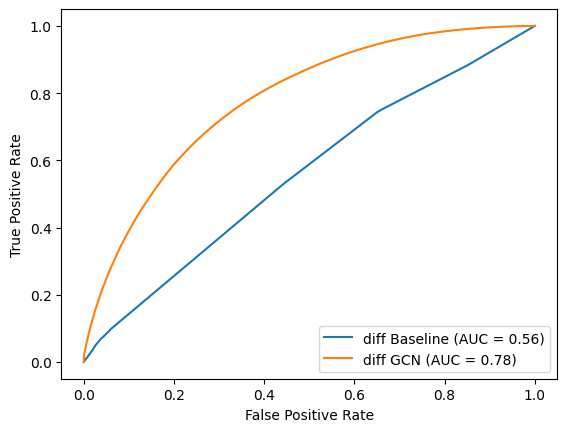

In [188]:
fig = plot_roc(dataset_names[3:4], y_all, y_probas_all_baseline, y_preds)

plt.savefig("Gplus_ROC.png")

In [ ]:
fig = plot_pr(dataset_names[3:4], y_all, y_probas_all_baseline, y_preds)

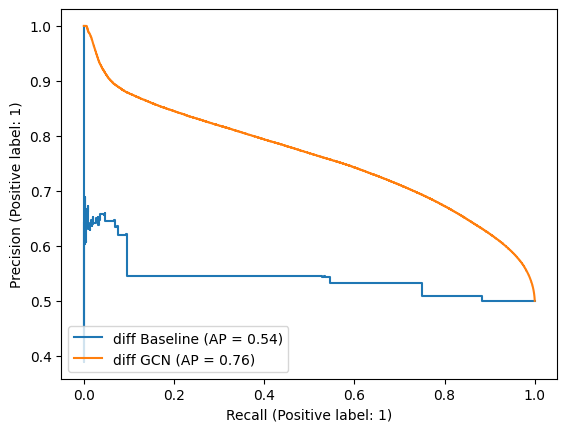

In [190]:
fig

<Axes: >

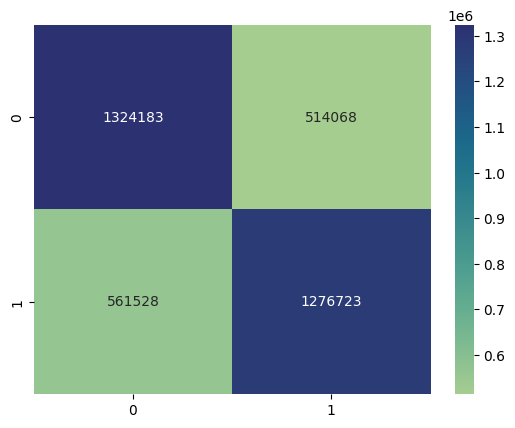

In [191]:
conf_mat = confusion_matrix(y_all[0], y_preds[0].round())
sns.heatmap(conf_mat, annot=True, cmap="crest", fmt=".0f")

In [192]:
#Accuracies
print(dataset_names[4], "Baseline", accuracy_score(y_all[0], y_probas_all_baseline[0].round()), "GCN", accuracy_score(y_all[0], y_preds[0].round()))

twitter_dataset_diff Baseline 0.5463329001317013 GCN 0.7074403876293281


## Twitter dataset

In [193]:
y_all, y_probas_all_baseline, y_preds = predict_baseline_and_model(datasets[4:], dataset_names[4:])

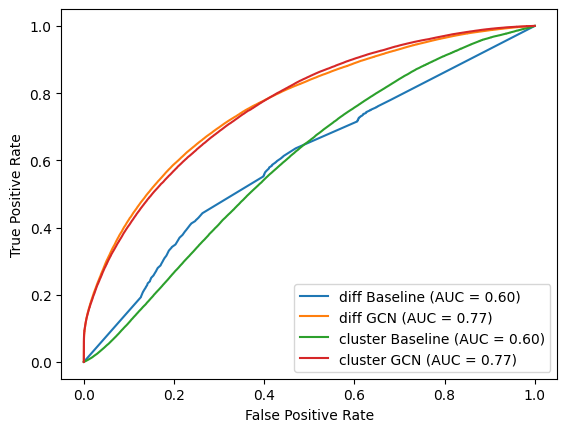

In [194]:
fig = plot_roc(dataset_names[4:], y_all, y_probas_all_baseline, y_preds)

plt.savefig("Twitter_ROC.png")

In [ ]:
fig = plot_pr(dataset_names[4:], y_all, y_probas_all_baseline, y_preds)

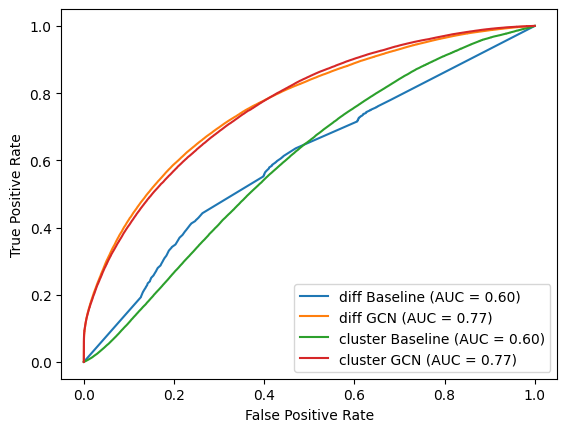

In [195]:
fig

<Axes: >

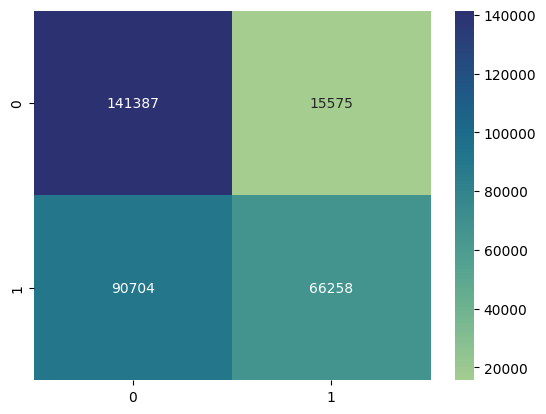

In [196]:
conf_mat = confusion_matrix(y_all[0], y_preds[0].round())
sns.heatmap(conf_mat, annot=True, cmap="crest", fmt=".0f")

In [197]:
#Accuracies
for i in range(len(y_preds)):
  print(dataset_names[4+i], "Baseline", accuracy_score(y_all[i], y_probas_all_baseline[i].round()), "GCN", accuracy_score(y_all[i], y_preds[i].round()))

twitter_dataset_diff Baseline 0.5847975943221926 GCN 0.6614499050725653
twitter_dataset_cluster Baseline 0.5797740854474331 GCN 0.6620232922618213
